In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
         
    for line in lines:
        for x1,y1,x2,y2 in line:
            alpha = math.atan2(y2-y1,x2-x1)
            x0 = int(round(x1 - 250 * math.cos(alpha)))
            y0 = int(round(y1 - 250 * math.sin(alpha)))
            cv2.line(img, (x1, y1), (x0, y0), color, thickness)
    """
    #Define different arrays and initialize y_min and y_max
    right_slope=[]
    right_x=[]
    right_y=[]
    left_slope=[]
    left_x=[]
    left_y=[]
    y_min=320
    y_max=img.shape[0]
    
    #Calculate slope and assign them to left/right side
    for line in lines:
        for x1,y1,x2,y2 in line:
            #identify global minimum y
            if y1<y_min:
                y_min=y1
            #Calculate slope and assign it likewise
            slope= (y2-y1)/(x2-x1)
            if slope<=0.2:
                left_slope.append(slope)
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
            elif slope>=0.2 and slope<=0.88:
                right_slope.append(slope)
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
    if right_slope:
        #Averaging the position of line segment right side
        avg_right_slope= np.median(right_slope)#sum(right_slope)/float(len(right_slope))
        avg_right_x=np.average(right_x)#sum(right_x)/float(len(right_x))
        avg_right_y=np.average(right_y)#sum(right_y)/float(len(right_y))
        #Calculate intercept for averaged right coordinates
        #print('rigth average is', avg_right_slope, right_slope)
        right_intercept= avg_right_y-(avg_right_slope*avg_right_x)
        #Find x1,x2 for highest point, we already have y1,y2
        x1_right=(y_min-right_intercept)/avg_right_slope
        x2_right=(y_max-right_intercept)/avg_right_slope
        #Draw right line
        cv2.line(img, (int(x1_right), y_min), (int(x2_right), y_max), color, thickness)
    
    if left_slope:
        #Averaging the position of line segment left side
        avg_left_slope= np.median(left_slope)#sum(left_slope)/float(len(left_slope))
        avg_left_x=sum(left_x)/float(len(left_x))
        avg_left_y=sum(left_y)/float(len(left_y))
        #Calculate intercept for averaged left coordinates
        left_intercept= avg_left_y-(avg_left_slope*avg_left_x)
        #Find x1,x2 for highest point, we already have y1,y2
        x1_left=(y_min-left_intercept)/avg_left_slope
        x2_left=(y_max-left_intercept)/avg_left_slope
        #Draw left line
        cv2.line(img, (int(x1_left), y_min), (int(x2_left), y_max), color, thickness)
        # average left and right slopes


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


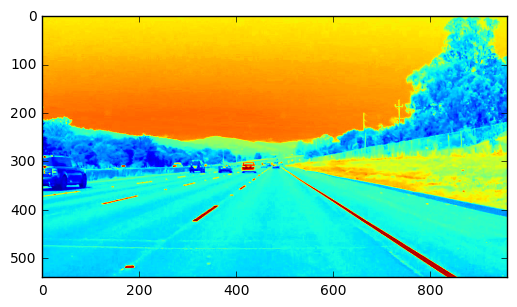

In [32]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
#plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
plt.imshow(grayscale(image))

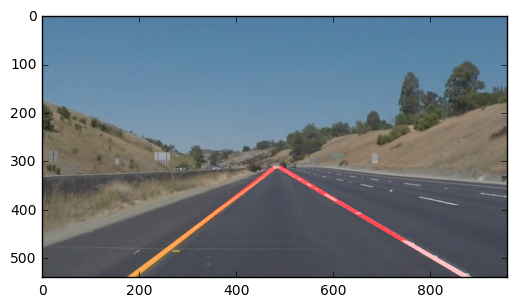

In [33]:
import os
images = os.listdir("test_images/")

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    #print('This image is:', type(image), 'with dimesions:', image.shape)
    #with kernal size 5
    blur_gray = gaussian_blur(grayscale(image),3)
    #thrashold with 50 and 150
    edges = canny(blur_gray,50,150) 

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    
    #vertices = np.array([[(0,imshape[0]),(450, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(110,imshape[0]),(410, 310),(480, 310), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges,vertices)
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell) 15
    min_line_length = 140 #minimum number of pixels making up a line
    max_line_gap = 100   # maximum gap in pixels between connectable line segments
    #line_image = np.copy(image)*0 # creating a blank to draw lines on
    line_image = hough_lines(masked_edges,rho,theta,threshold,min_line_length, max_line_gap)
    mm_line_images = region_of_interest(line_image,vertices)
    color_edges = np.dstack((edges, edges, edges)) 
    #lines_edges = weighted_img(line_image,color_edges)
    lines_edges = weighted_img(line_image,image)
    #mpimg.imsave("test_images/after-"+img,lines_edges)
    plt.imshow(lines_edges)
    
    return lines_edges

for img in images:
    image= mpimg.imread("test_images/"+img)
    process_image(image)
    

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4





  0%|          | 0/222 [00:00<?, ?it/s]


  2%|▏         | 4/222 [00:00<00:05, 37.95it/s]


  4%|▎         | 8/222 [00:00<00:05, 38.52it/s]


  5%|▌         | 12/222 [00:00<00:05, 38.37it/s]


  7%|▋         | 16/222 [00:00<00:05, 38.47it/s]


  9%|▉         | 20/222 [00:00<00:05, 38.82it/s]


 11%|█         | 24/222 [00:00<00:05, 38.44it/s]


 13%|█▎        | 28/222 [00:00<00:04, 38.86it/s]


 15%|█▍        | 33/222 [00:00<00:04, 39.24it/s]


 17%|█▋        | 37/222 [00:00<00:04, 39.29it/s]


 19%|█▉        | 42/222 [00:01<00:04, 39.56it/s]


 21%|██        | 46/222 [00:01<00:04, 39.36it/s]


 23%|██▎       | 50/222 [00:01<00:04, 39.12it/s]


 24%|██▍       | 54/222 [00:01<00:04, 37.47it/s]


 26%|██▌       | 58/222 [00:01<00:04, 36.68it/s]


 28%|██▊       | 62/222 [00:01<00:04, 36.05it/s]


 30%|██▉       | 66/222 [00:01<00:04, 36.13it/s]


 32%|███▏      | 70/222 [00:01<00:04, 35.82it/s]


 33%|███▎      | 74/222 [00:01<00:04, 34.44it/s]


 35%|███▌      | 78/222 [00:02<00:04, 3

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.08 s, sys: 405 ms, total: 5.49 s
Wall time: 6.46 s


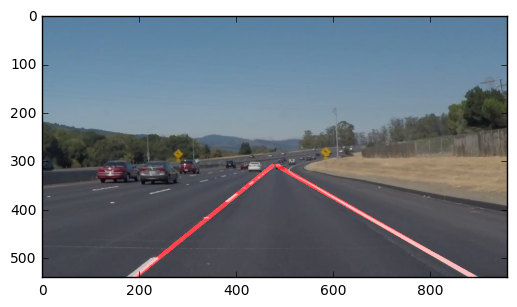

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4





  0%|          | 0/682 [00:00<?, ?it/s]


  1%|          | 4/682 [00:00<00:18, 36.81it/s]


  1%|▏         | 9/682 [00:00<00:17, 37.91it/s]


  2%|▏         | 12/682 [00:00<00:19, 35.00it/s]


  2%|▏         | 17/682 [00:00<00:18, 36.46it/s]


  3%|▎         | 22/682 [00:00<00:17, 37.79it/s]


  4%|▍         | 27/682 [00:00<00:16, 38.81it/s]


  5%|▍         | 32/682 [00:00<00:16, 39.63it/s]


  5%|▌         | 37/682 [00:00<00:15, 40.36it/s]


  6%|▌         | 41/682 [00:01<00:16, 39.73it/s]


  7%|▋         | 45/682 [00:01<00:16, 39.17it/s]


  7%|▋         | 49/682 [00:01<00:16, 37.67it/s]


  8%|▊         | 53/682 [00:01<00:17, 36.80it/s]


  8%|▊         | 57/682 [00:01<00:17, 35.53it/s]


  9%|▉         | 61/682 [00:01<00:17, 35.18it/s]


 10%|▉         | 65/682 [00:01<00:17, 34.96it/s]


 10%|█         | 69/682 [00:01<00:17, 35.32it/s]


 11%|█         | 73/682 [00:01<00:17, 35.39it/s]


 11%|█▏        | 77/682 [00:02<00:16, 35.68it/s]


 12%|█▏        | 81/682 [00:02<00:16, 3

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 15.6 s, sys: 1.24 s, total: 16.9 s
Wall time: 19.6 s


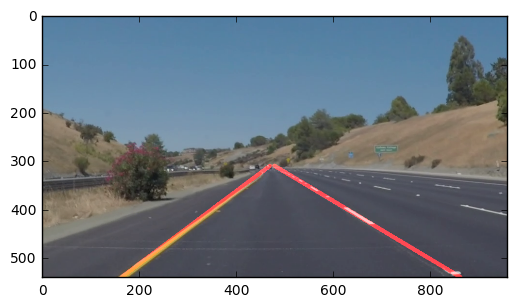

In [35]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

#HTML("""
#<video width="960" height="540" controls>
#  <source src="{0}">
#</video>
#""".format(yellow_output))

In [36]:
#challenge_output = 'extra.mp4'
#clip2 = VideoFileClip('challenge.mp4')
#challenge_clip = clip2.fl_image(process_image)
#%time challenge_clip.write_videofile(challenge_output, audio=False)